In [1]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
df_self = pd.read_csv("src/data/selfservice.csv")
df_happy = pd.read_csv("src/data/caminhofeliz.csv")
#df_original["Quantidade de Motoristas"] = df_original["Quantidade de Motoristas"].astype(int)

df_self = df_self.loc[:, ~df_self.columns.str.contains('^Unnamed')]
df_happy = df_happy.loc[:, ~df_happy.columns.str.contains('^Unnamed')]

df_self["created_at"] = pd.to_datetime(df_self["created_at"], errors="coerce")
df_happy["created_at"] = pd.to_datetime(df_happy["created_at"], errors="coerce")

df_self["creted_at_analist_success"] = pd.to_datetime(df_self["creted_at_analist_success"], errors="coerce")
df_happy["creted_at_analist_success"] = pd.to_datetime(df_happy["creted_at_analist_success"], errors="coerce")



Nome do estudo: 9 - Impacto do caminho feliz no churn
Hash numérica de 5 dígitos: 20860
Execução em: 2025-04-03 14:59:26


# apenas_self

In [14]:
# obtenção das informações das empresas que atuaram apenas modelo self

# 1. Selecionar empresas exclusivas do modelo self
# -------------------------------
empresas_self = set(df_self["company_id"])
empresas_happy = set(df_happy["company_id"])
empresas_so_self = empresas_self - empresas_happy

df_self_exclusivo = df_self[df_self["company_id"].isin(empresas_so_self)].copy()


# -------------------------------
# 2. Gerar resumo por empresa
# -------------------------------

# Contratos por empresa
contratos_por_empresa = (
    df_self_exclusivo
    .groupby(["company_id", "company", "qtd_trucks"])
    .size()
    .reset_index(name="qtd_contratos")
)

# Último status do cliente
ultimo_status_self = (
    df_self_exclusivo
    .sort_values(by=["company_id", "created_at"])
    .groupby("company_id")
    .last()
    .reset_index()[["company_id", "client_status"]]
    .rename(columns={"client_status": "ultimo_status"})
)

# Quantidade de contratos por status
status_contratos = (
    df_self_exclusivo
    .groupby(["company_id", "contract_status"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Datas mínima e máxima dos contratos
datas_contratos_self = (
    df_self_exclusivo
    .groupby("company_id")["created_at"]
    .agg(["min", "max"])
    .reset_index()
)
datas_contratos_self["dias_entre_contratos"] = (
    (datas_contratos_self["max"] - datas_contratos_self["min"]).dt.days
)

# -------------------------------
# 3. Juntar todas as informações
# -------------------------------
resumo_so_self = (
    contratos_por_empresa
    .merge(ultimo_status_self, on="company_id")
    .merge(status_contratos, on="company_id")
    .merge(datas_contratos_self, on="company_id")
)

resumo_so_self = resumo_so_self.sort_values(by="qtd_contratos", ascending=False)

print("Transportadoras que atuaram somente no modelo self-service")
print("Número de transportadoras:", len(resumo_so_self))

# -------------------------------
# 4. Verificar e tratar responsáveis
# -------------------------------

# Obter responsáveis e telefones únicos por empresa
responsaveis_por_empresa = (
    df_self_exclusivo
    .groupby("company_id")[["responsavel", "phone"]]
    .agg(lambda x: x.dropna().unique().tolist())
    .reset_index()
)

# Identificar empresas com múltiplos responsáveis
responsaveis_por_empresa["qtd_responsaveis"] = responsaveis_por_empresa["responsavel"].apply(len)
empresas_multiplos_responsaveis = responsaveis_por_empresa[
    responsaveis_por_empresa["qtd_responsaveis"] > 1
]

# Emitir aviso se houver mais de um responsável
if not empresas_multiplos_responsaveis.empty:
    print("⚠️ Atenção: há empresas com mais de um responsável:")
    print(empresas_multiplos_responsaveis[["company_id", "responsavel", "phone"]])

# Manter apenas o primeiro responsável e telefone
responsaveis_por_empresa["responsavel"] = responsaveis_por_empresa["responsavel"].apply(
    lambda x: x[0] if x else None
)
responsaveis_por_empresa["phone"] = responsaveis_por_empresa["phone"].apply(
    lambda x: x[0] if x else None
)

# -------------------------------
# 5. Adicionar responsáveis ao resumo
# -------------------------------
apenas_self = resumo_so_self.merge(
    responsaveis_por_empresa[["company_id", "responsavel", "phone"]],
    on="company_id",
    how="left"
)
apenas_self.to_csv(
    "/home/deboragomes/Área de trabalho/debora_faria_2025/9 - Impacto do caminho feliz no churn/src/data/resultado_apenas_self.csv",
    index=False,
    encoding="utf-8-sig"
)

# Exibir o resultado final
apenas_self.head(3)


Transportadoras que atuaram somente no modelo self-service
Número de transportadoras: 31


,company_id,company,qtd_trucks,qtd_contratos,ultimo_status,A caminho,Cancelada,Esperando Avaliação,Finalizada,min,max,dias_entre_contratos,responsavel,phone
0,3434,AL TRANSPORTES,60,10,Inativo,0,4,0,6,2024-12-06 17:06:26,2024-12-06 17:10:50,0,EDER ALENCAR,+55 (83) 9 9676-8502
1,3750,AMBIPAR ENVIRONMENTAL SOLUTIONS - SOLUCOES AMB...,14,5,Ativo,0,3,0,2,2025-02-04 10:26:09,2025-02-18 09:42:09,13,AMBIPAR ENVIRONMENTAL SOLUTIONS - SOLUCOES AMB...,+55 (15) 9 9766-9254
2,3814,AGEBRANDS COMERCIO E PARTICIPAÇÕES LTDA,2,5,Inativo,0,0,0,5,2024-12-23 10:42:11,2024-12-23 10:42:53,0,MARCO AURELIO,+55 (11) 9 4794-6140


In [45]:
# Total de empresas
total_empresas = apenas_self['company_id'].nunique()

# Empresas com menos de 10 veículos
empresas_menos_10 = apenas_self[apenas_self['qtd_trucks'] < 10]['company_id'].nunique()

# Total de contratos lançados
total_contratos = apenas_self['qtd_contratos'].sum()

# Total de contratos cancelados
total_cancelados = apenas_self['Cancelada'].sum()
percent_cancelado = total_cancelados / total_contratos * 100

# Empresas com qtd_trucks == 0
qtd_trucks_zero = apenas_self[apenas_self['qtd_trucks'] == 0]['company_id'].nunique()

# Exibir resultados
print('INFORMAÇÕES SOBRE AS QUE LANÇARAM SOMENTE SELF')
print(f"Total de empresas: {total_empresas}")
print(f"Empresas com menos de 10 veículos: {empresas_menos_10}")
print(f"Total de contratos lançados: {total_contratos}")
print(f"Contratos cancelados: {total_cancelados} ({percent_cancelado:.1f}%)")
print(f"Empresas com qtd_trucks = 0: {qtd_trucks_zero}")


INFORMAÇÕES SOBRE AS QUE LANÇARAM SOMENTE SELF
Total de empresas: 31
Empresas com menos de 10 veículos: 16
Total de contratos lançados: 62
Contratos cancelados: 26 (41.9%)
Empresas com qtd_trucks = 0: 2


## de_self_para_happy

In [3]:
def resumir_migracao_para_happy(df_self, df_happy):

    # Marcar origem
    df_self["caminho"] = "self"
    df_happy["caminho"] = "happy"

    # Usar apenas empresas que têm contratos nos dois caminhos
    empresas_em_ambos = set(df_self["company_id"]).intersection(set(df_happy["company_id"]))
    df_self_ambos = df_self[df_self["company_id"].isin(empresas_em_ambos)].copy()
    df_happy_ambos = df_happy[df_happy["company_id"].isin(empresas_em_ambos)].copy()

    # Consolidar e ordenar
    todos_contratos = pd.concat([df_self_ambos, df_happy_ambos], ignore_index=True)
    todos_contratos = todos_contratos.sort_values(by=["company_id", "created_at"])

    # Verificar o primeiro caminho
    primeiro_contrato = (
        todos_contratos.groupby("company_id")
        .first()
        .reset_index()[["company_id", "caminho"]]
    )

    # Empresas que começaram no self
    empresas_comecaram_self = primeiro_contrato[primeiro_contrato["caminho"] == "self"]["company_id"]

    # Filtrar contratos dessas empresas
    df_self_migraram = df_self[df_self["company_id"].isin(empresas_comecaram_self)].copy()
    df_happy_migraram = df_happy[df_happy["company_id"].isin(empresas_comecaram_self)].copy()

    # Contagens
    contagem_self = df_self_migraram.groupby("company_id").size().reset_index(name="contratos_self")
    contagem_happy = df_happy_migraram.groupby("company_id").size().reset_index(name="contratos_happy")
    nomes = df_self_migraram[["company_id", "company"]].drop_duplicates()

    # Datas de referência
    primeira_data_self = df_self_migraram.groupby("company_id")["created_at"] \
        .min().reset_index().rename(columns={"created_at": "primeira_data_self"})
    primeira_data_happy = df_happy_migraram.groupby("company_id")["created_at"] \
        .min().reset_index().rename(columns={"created_at": "primeira_data_happy"})

    # Último status
    df_completo = pd.concat([df_self_migraram, df_happy_migraram])
    ultimo_status = (
        df_completo.sort_values(by=["company_id", "created_at"])
        .groupby("company_id")
        .last()
        .reset_index()[["company_id", "client_status", "created_at"]]
        .rename(columns={"client_status": "ultimo_status", "created_at": "ultima_data_criacao"})
    )

    # Juntar tudo
    resumo = (
        nomes
        .merge(contagem_self, on="company_id")
        .merge(contagem_happy, on="company_id")
        .merge(primeira_data_self, on="company_id")
        .merge(primeira_data_happy, on="company_id")
        .merge(ultimo_status, on="company_id")
    )

    # Calcular dias até migrar para o happy
    resumo["dias_ate_migrar"] = (resumo["primeira_data_happy"] - resumo["primeira_data_self"]).dt.days

    # Ajustar formato de data final
    resumo["ultima_data_criacao"] = resumo["ultima_data_criacao"].dt.date

    # Reordenar colunas
    resumo = resumo[
        ["company_id", "company", "contratos_self", "contratos_happy", "ultimo_status",
         "primeira_data_self", "primeira_data_happy", "dias_ate_migrar", "ultima_data_criacao"]
    ]

    return resumo.sort_values(by="dias_ate_migrar")

de_self_para_happy = resumir_migracao_para_happy(df_self, df_happy)

# 2. Obter qtd_trucks do primeiro contrato self
qtd_trucks_por_empresa = (
    df_self[df_self["company_id"].isin(de_self_para_happy["company_id"])]
    .sort_values(by=["company_id", "created_at"])
    .groupby("company_id")
    .first()
    .reset_index()[["company_id", "qtd_trucks"]]
)

# Obter responsavel e phone do último contrato happy
contato_mais_recente = (
    df_happy[df_happy["company_id"].isin(de_self_para_happy["company_id"])]
    .sort_values(by=["company_id", "created_at"])
    .groupby("company_id")
    .last()
    .reset_index()[["company_id", "responsavel", "phone"]]
)

# Juntar com de_self_para_happy
de_self_para_happy = (
    de_self_para_happy
    .merge(qtd_trucks_por_empresa, on="company_id", how="left")
    .merge(contato_mais_recente, on="company_id", how="left")
)


def gerar_faixa_semana_num(dias):
    if dias == 0:
        return 0
    else:
        return int(np.ceil(dias / 15))  
de_self_para_happy['semana'] = de_self_para_happy['dias_ate_migrar'].apply(gerar_faixa_semana_num)



de_self_para_happy['retencao'] = np.where(
    de_self_para_happy['ultimo_status'].isin(['Ativo', 'Recorrente']),
    'sim',
    'nao'
)
de_self_para_happy = de_self_para_happy.loc[de_self_para_happy.dias_ate_migrar < 16]
display(de_self_para_happy.head(3))

,company_id,company,contratos_self,contratos_happy,ultimo_status,primeira_data_self,primeira_data_happy,dias_ate_migrar,ultima_data_criacao,qtd_trucks,responsavel,phone,semana,retencao
0,4363,RUE DE FRANCE,2,2,Ativo,2025-04-01 12:21:46,2025-04-01 17:28:57,0,2025-04-02,0,JEREMY CHALEIL,+55 (11) 9 5520-1205,0,sim
1,4258,ANX Ind. Com. Produtos Plásticos Ltda.,1,2,Ativo,2025-03-19 15:07:12,2025-03-20 11:31:49,0,2025-03-20,2,MARIANA CASARINI ALVES,+55 (11) 9 7481-1753,0,sim
2,4156,Ars Express,1,1,Ativo,2025-03-12 17:47:20,2025-03-13 17:40:18,0,2025-03-13,4,ALEXANDRE,+55 (11) 9 9988-5870,0,sim


In [44]:
# 1. Empresas que migraram
empresas_migraram = de_self_para_happy['company_id'].unique()
total_empresas = len(empresas_migraram)

# 2. Empresas com menos de 10 veículos
empresas_menos_10 = de_self_para_happy[de_self_para_happy['qtd_trucks'] < 10]['company_id'].nunique()

# 3. Total de contratos lançados (somando self e happy)
total_contratos = de_self_para_happy['contratos_self'].sum() + de_self_para_happy['contratos_happy'].sum()

# 4. Total de cancelados nas duas bases
cancelados_self = df_self[
    df_self['company_id'].isin(empresas_migraram) &
    (df_self['contract_status'] == 'Cancelada')
].shape[0]

cancelados_happy = df_happy[
    df_happy['company_id'].isin(empresas_migraram) &
    (df_happy['contract_status'] == 'Cancelada')
].shape[0]

total_cancelados = cancelados_self + cancelados_happy
percent_cancelado = total_cancelados / total_contratos * 100

# 5. Empresas com qtd_trucks == 0
qtd_trucks_zero = de_self_para_happy[de_self_para_happy['qtd_trucks'] == 0]['company_id'].nunique()

# 5. Resultado
print('INFORMAÇÕES SOBRE AS QUE COMEÇARAM SELF E DEPOIS LANÇARAM HAPPY')
print(f"Total de empresas que migraram do self para o happy: {total_empresas}")
print(f"Empresas com menos de 10 veículos: {empresas_menos_10}")
print(f"Total de contratos lançados: {total_contratos}")
print(f"Contratos cancelados: {total_cancelados} ({percent_cancelado:.1f}%)")
print(f"Empresas com qtd_trucks = 0: {qtd_trucks_zero}")


INFORMAÇÕES SOBRE AS QUE COMEÇARAM SELF E DEPOIS LANÇARAM HAPPY
Total de empresas que migraram do self para o happy: 83
Empresas com menos de 10 veículos: 27
Total de contratos lançados: 2647
Contratos cancelados: 695 (26.3%)
Empresas com qtd_trucks = 0: 4


## dias

In [4]:
# -------------------------
# Função principal
# -------------------------

def resumir_migracao_para_happy(df_self, df_happy):
    df_self["caminho"] = "self"
    df_happy["caminho"] = "happy"

    # Empresas com contratos nos dois caminhos
    empresas_em_ambos = set(df_self["company_id"]).intersection(set(df_happy["company_id"]))
    df_self_ambos = df_self[df_self["company_id"].isin(empresas_em_ambos)].copy()
    df_happy_ambos = df_happy[df_happy["company_id"].isin(empresas_em_ambos)].copy()

    # Consolidar contratos ordenados
    todos_contratos = pd.concat([df_self_ambos, df_happy_ambos], ignore_index=True)
    todos_contratos = todos_contratos.sort_values(by=["company_id", "created_at"])

    # Descobrir caminho inicial
    primeiro_contrato = (
        todos_contratos.groupby("company_id").first().reset_index()[["company_id", "caminho"]]
    )
    empresas_comecaram_self = primeiro_contrato.query("caminho == 'self'")["company_id"]

    # Dados apenas das empresas que migraram
    df_self_migraram = df_self[df_self["company_id"].isin(empresas_comecaram_self)].copy()
    df_happy_migraram = df_happy[df_happy["company_id"].isin(empresas_comecaram_self)].copy()

    # Contagem de contratos
    contagem_self = df_self_migraram.groupby("company_id").size().reset_index(name="contratos_self")
    contagem_happy = df_happy_migraram.groupby("company_id").size().reset_index(name="contratos_happy")
    nomes = df_self_migraram[["company_id", "company"]].drop_duplicates()

    # Datas
    primeira_data_self = df_self_migraram.groupby("company_id")["created_at"].min().reset_index(name="primeira_data_self")
    primeira_data_happy = df_happy_migraram.groupby("company_id")["created_at"].min().reset_index(name="primeira_data_happy")

    # Último status
    df_completo = pd.concat([df_self_migraram, df_happy_migraram])
    ultimo_status = (
        df_completo.sort_values(by=["company_id", "created_at"])
        .groupby("company_id").last().reset_index()[["company_id", "client_status", "created_at"]]
        .rename(columns={"client_status": "ultimo_status", "created_at": "ultima_data_criacao"})
    )

    # Juntar tudo
    resumo = (
        nomes.merge(contagem_self, on="company_id")
             .merge(contagem_happy, on="company_id")
             .merge(primeira_data_self, on="company_id")
             .merge(primeira_data_happy, on="company_id")
             .merge(ultimo_status, on="company_id")
    )

    # Calcular tempo até migração
    resumo["dias_ate_migrar"] = (resumo["primeira_data_happy"] - resumo["primeira_data_self"]).dt.days
    resumo["ultima_data_criacao"] = resumo["ultima_data_criacao"].dt.date

    # Reordenar colunas
    return resumo[[
        "company_id", "company", "contratos_self", "contratos_happy", "ultimo_status",
        "primeira_data_self", "primeira_data_happy", "dias_ate_migrar", "ultima_data_criacao"
    ]].sort_values(by="dias_ate_migrar")

# -------------------------
# Aplicação da função
# -------------------------

de_self_para_happy = resumir_migracao_para_happy(df_self, df_happy)

# -------------------------
# Pós-processamento
# -------------------------

# Qtd. trucks no primeiro contrato self
qtd_trucks_por_empresa = (
    df_self[df_self["company_id"].isin(de_self_para_happy["company_id"])]
    .sort_values(by=["company_id", "created_at"])
    .groupby("company_id").first().reset_index()[["company_id", "qtd_trucks"]]
)

# Contato mais recente no happy
contato_mais_recente = (
    df_happy[df_happy["company_id"].isin(de_self_para_happy["company_id"])]
    .sort_values(by=["company_id", "created_at"])
    .groupby("company_id").last().reset_index()[["company_id", "responsavel", "phone"]]
)

# Juntar colunas no resumo principal
de_self_para_happy = (
    de_self_para_happy
    .merge(qtd_trucks_por_empresa, on="company_id", how="left")
    .merge(contato_mais_recente, on="company_id", how="left")
)

# Faixa em semanas (15 dias por faixa)
def gerar_faixa_semana_num(dias):
    return 0 if dias == 0 else int(np.ceil(dias / 15))

de_self_para_happy["semana"] = de_self_para_happy["dias_ate_migrar"].apply(gerar_faixa_semana_num)

# Define retenção final
de_self_para_happy["retencao"] = np.where(
    de_self_para_happy["ultimo_status"].isin(["Ativo", "Recorrente"]),
    "sim", "nao"
)

# Filtra para empresas que migraram em até 15 dias
de_self_para_happy = de_self_para_happy[de_self_para_happy["dias_ate_migrar"] < 16]

# Visualizar os 3 primeiros registros
display(de_self_para_happy.head(3))


,company_id,company,contratos_self,contratos_happy,ultimo_status,primeira_data_self,primeira_data_happy,dias_ate_migrar,ultima_data_criacao,qtd_trucks,responsavel,phone,semana,retencao
0,4363,RUE DE FRANCE,2,2,Ativo,2025-04-01 12:21:46,2025-04-01 17:28:57,0,2025-04-02,0,JEREMY CHALEIL,+55 (11) 9 5520-1205,0,sim
1,4258,ANX Ind. Com. Produtos Plásticos Ltda.,1,2,Ativo,2025-03-19 15:07:12,2025-03-20 11:31:49,0,2025-03-20,2,MARIANA CASARINI ALVES,+55 (11) 9 7481-1753,0,sim
2,4156,Ars Express,1,1,Ativo,2025-03-12 17:47:20,2025-03-13 17:40:18,0,2025-03-13,4,ALEXANDRE,+55 (11) 9 9988-5870,0,sim


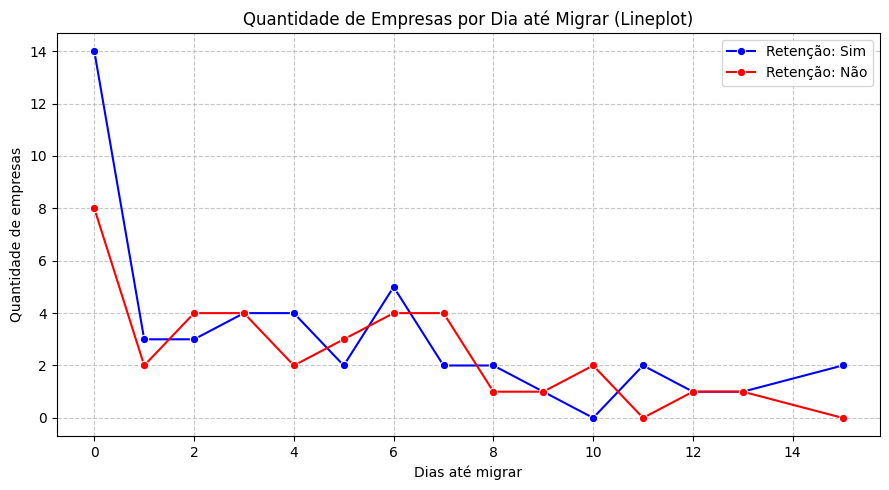

In [5]:
# grafico df_dias
df_dias = (
    de_self_para_happy
    .groupby(['dias_ate_migrar', 'retencao'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

df_dias_reset = df_dias.reset_index()

plt.figure(figsize=(9, 5))
sns.lineplot(data=df_dias_reset, x='dias_ate_migrar', y='sim', label='Retenção: Sim', color='blue', marker='o')
sns.lineplot(data=df_dias_reset, x='dias_ate_migrar', y='nao', label='Retenção: Não', color='red', marker='o')

plt.title('Quantidade de Empresas por Dia até Migrar (Lineplot)')
plt.xlabel('Dias até migrar')
plt.ylabel('Quantidade de empresas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

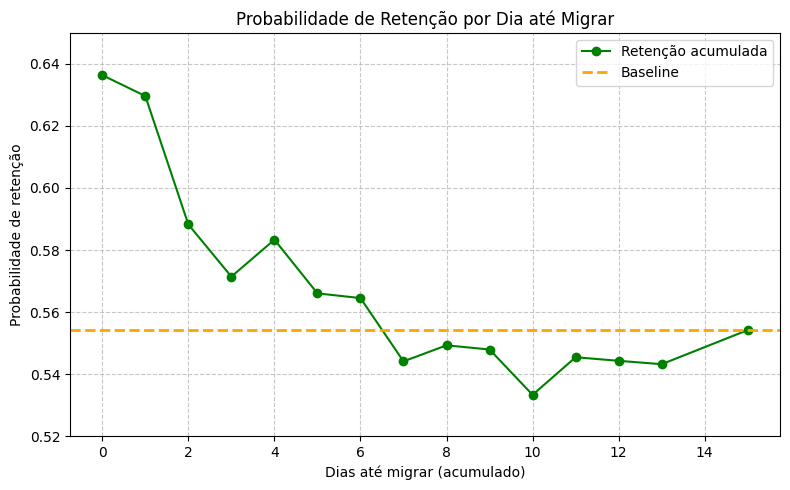

In [18]:
# Ordena o DataFrame pelos dias até migrar
df_ord = de_self_para_happy.sort_values('dias_ate_migrar')

# Lista de dias únicos ordenados
dias = sorted(df_ord['dias_ate_migrar'].unique())

# Lista pra armazenar (dia, probabilidade acumulada)
acumulado = []

for d in dias:
    subset = df_ord[df_ord['dias_ate_migrar'] <= d]
    total = len(subset)
    retidos = (subset['retencao'] == 'sim').sum()
    prob = retidos / total if total > 0 else np.nan
    acumulado.append((d, prob))


df_acumulado_dias = pd.DataFrame(acumulado, columns=['dias_ate_migrar', 'prob_retencao'])

baseline = (de_self_para_happy['retencao'] == 'sim').mean()

plt.figure(figsize=(8, 5))
plt.plot(df_acumulado_dias['dias_ate_migrar'], df_acumulado_dias['prob_retencao'],
         marker='o', color='green', label='Retenção acumulada')
plt.axhline(y=baseline, color='orange', linestyle='--', linewidth=2, label='Baseline')

plt.title('Probabilidade de Retenção por Dia até Migrar')
plt.xlabel('Dias até migrar (acumulado)')
plt.ylabel('Probabilidade de retenção')
plt.ylim(0.52, 0.65)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

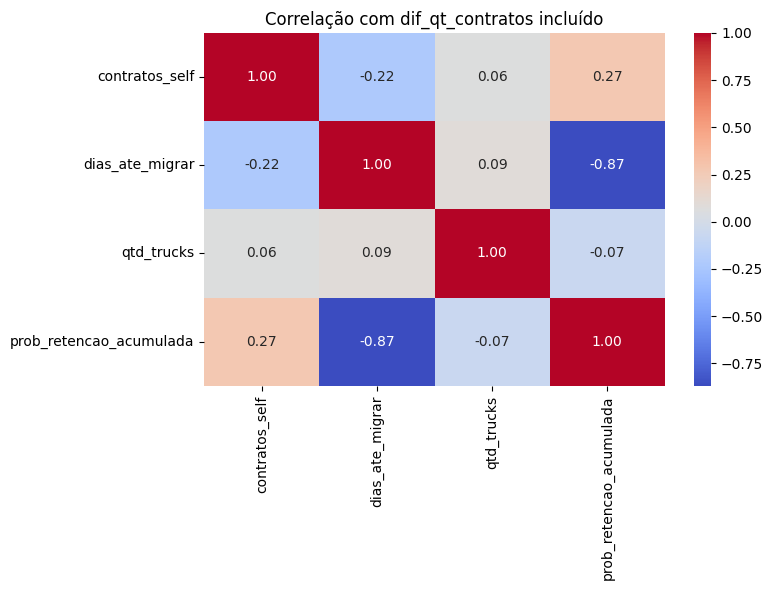

In [8]:
# para correlação

df_ord = de_self_para_happy.sort_values('dias_ate_migrar')


acumulado = []
for d in sorted(df_ord['dias_ate_migrar'].unique()):
    subset = df_ord[df_ord['dias_ate_migrar'] <= d]
    total = len(subset)
    retidos = (subset['retencao'] == 'sim').sum()
    prob = retidos / total if total > 0 else np.nan
    acumulado.append((d, prob))

df_retencao_por_dia = pd.DataFrame(acumulado, columns=['dias_ate_migrar', 'prob_retencao_acumulada'])

df_completo = pd.merge(de_self_para_happy, df_retencao_por_dia, on='dias_ate_migrar', how='left')

df_completo['dif_qt_contratos'] = df_completo['contratos_happy'] - df_completo['contratos_self']


colunas_corr = [
    'contratos_self',
    'dias_ate_migrar',
   'qtd_trucks',
    'prob_retencao_acumulada'
]

# Matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(df_completo[colunas_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação com dif_qt_contratos incluído')
plt.tight_layout()
plt.show()


In [34]:
# pca

colunas_pca = ['dias_ate_migrar', 'prob_retencao_acumulada']

X = df_completo[colunas_pca].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 1)  
X_pca = pca.fit_transform(X_scaled)

print("Variância explicada:", pca.explained_variance_ratio_)


Variância explicada: [0.93422154]


In [47]:
# Cria rankings dos valores de PCA
df_completo['PCA_rank'] = df_completo['PCA'].rank(method='first').round(2)

# Aplica corte em 4 grupos do mesmo tamanho com base no rank
df_completo['PCA_quantile'] = pd.qcut(df_completo['PCA_rank'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Agora você pode agrupar e tirar as médias por quartil
df_completo.groupby('PCA_quantile')[colunas_pca].mean().round(1)


# Resultado esperado
print(df_completo['PCA_quantile'].value_counts())


df_completo.PCA_quantile.value_counts()

df_completo.groupby('PCA_quantile')[colunas_pca].mean().round(4)

PCA_quantile
Q1    21
Q2    21
Q4    21
Q3    20
Name: count, dtype: int64


/tmp/ipykernel_93512/1593755022.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_completo.groupby('PCA_quantile')[colunas_pca].mean().round(1)
/tmp/ipykernel_93512/1593755022.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_completo.groupby('PCA_quantile')[colunas_pca].mean().round(4)


,dias_ate_migrar,prob_retencao_acumulada
PCA_quantile,,
Q1,9.8095,0.5452
Q2,4.7619,0.5672
Q3,2.3000,0.5987
Q4,0.0000,0.6364


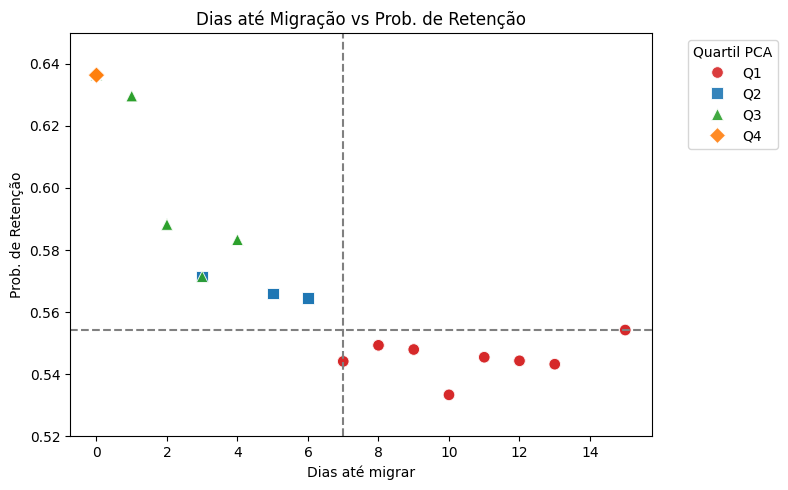

In [39]:
# Baseline
baseline = 0.5542

# Paleta (Q1 vermelho)
custom_palette = {
    'Q1': '#d62728',
    'Q2': '#1f77b4',
    'Q3': '#2ca02c',
    'Q4': '#ff7f0e'
}

# Marcadores por quartil
custom_markers = {
    'Q1': 'o',
    'Q2': 's',
    'Q3': '^',
    'Q4': 'D'
}

# Figura única
fig, ax = plt.subplots(figsize=(8, 5))

# Gráfico de dispersão
sns.scatterplot(
    data=df_completo,
    x='dias_ate_migrar',
    y='prob_retencao_acumulada',
    hue='PCA_quantile',
    style='PCA_quantile',
    palette=custom_palette,
    markers=custom_markers,
    alpha=0.9,
    s=70,
    ax=ax
)

# Linhas de referência
ax.axhline(baseline, color='gray', linestyle='--')
ax.axvline(x=7, color='gray', linestyle='--')

# Ajustes visuais
ax.set_title('Dias até Migração vs Prob. de Retenção')
ax.set_ylabel('Prob. de Retenção')
ax.set_xlabel('Dias até migrar')
ax.set_ylim(0.52, 0.65)

# Legenda
ax.legend(title='Quartil PCA', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
